In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import sys 
import pdb
import pandas as pd
import pickle
from pyuoi.linear_model.var import VAR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from tqdm import tqdm
from glob import glob

In [4]:
sys.path.append('/home/akumar/nse/neural_control')

In [5]:
from loaders import load_sabes, load_peanut, load_cv
from segmentation import reach_segment_sabes
from utils import form_companion, calc_loadings, apply_df_filters
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from dca.cov_util import form_lag_matrix

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Analysis 1: How do the modes in ambient VAR fits correlate with subspace angles of FCCA/PCA? Is there any relationship between real vs. imaginary component and eigenvector condition number?

In [6]:
with open('/mnt/Secondary/data/postprocessed/indy_decoding_df2.dat', 'rb') as f:
    rl = pickle.load(f)
indy_df = pd.DataFrame(rl)

with open('/mnt/Secondary/data/postprocessed/loco_decoding_df.dat', 'rb') as f:
    loco_df = pickle.load(f)
loco_df = pd.DataFrame(loco_df)
loco_df = apply_df_filters(loco_df,
                        loader_args={'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'spike_threshold': 100, 'region': 'M1'},
                        decoder_args={'trainlag': 4, 'testlag': 4, 'decoding_window': 5})
good_loco_files = ['loco_20170210_03.mat',
'loco_20170213_02.mat',
'loco_20170215_02.mat',
'loco_20170227_04.mat',
'loco_20170228_02.mat',
'loco_20170301_05.mat',
'loco_20170302_02.mat']

loco_df = apply_df_filters(loco_df, data_file=good_loco_files)        

sabes_df = pd.concat([indy_df, loco_df])

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [10]:
# Fit VAR(1) using OLS to each data file
rl = []
path = '/mnt/Secondary/data/sabes'
for i, data_file in tqdm(enumerate(np.unique(sabes_df['data_file'].values))): 
    dat = load_sabes('%s/%s' % (path, data_file), region='M1')
    X = dat['spike_rates'].squeeze()
    xsmooth = scipy.ndimage.gaussian_filter1d(X, sigma=1, axis=0)

    r = {}
    A = []

    for train_idxs, test_idxs in tqdm(KFold(n_splits=5).split(xsmooth)):
        xtrain = xsmooth[train_idxs]
        xtest = xsmooth[test_idxs]

        xtrain = StandardScaler().fit_transform(xtrain)
        xtest = StandardScaler().fit_transform(xtest)

        xdiff_train = StandardScaler().fit_transform(np.diff(xtrain, axis=0))
        xdiff_test = StandardScaler().fit_transform(np.diff(xtest, axis=0))

        linmodel = LinearRegression().fit(xtrain[:-1, :], xdiff_train)

        A.append(linmodel.coef_)
    r['A'] = A
    r['data_file'] = data_file
    rl.append(r)

0it [00:00, ?it/s]

5it [00:01,  3.65it/s]
5it [00:01,  2.89it/s]
5it [00:00, 18.50it/s]
5it [00:02,  2.09it/s]
5it [00:00, 10.12it/s]
5it [00:00, 32.04it/s]
5it [00:00, 28.95it/s]
5it [00:00, 22.78it/s]
5it [00:00, 29.69it/s]
5it [00:00, 35.04it/s]
5it [00:00, 22.17it/s]]
5it [00:00, 22.83it/s]]
5it [00:00, 14.64it/s]]
5it [00:00, 23.93it/s]]
5it [00:00, 21.09it/s]]
5it [00:00, 24.88it/s]]
5it [00:00, 27.35it/s]]
5it [00:00, 23.05it/s]]
5it [00:00, 25.43it/s]]
5it [00:00, 19.37it/s]]
5it [00:00, 17.43it/s]]
5it [00:00, 28.22it/s]]
5it [00:00, 24.64it/s]]
5it [00:00, 26.34it/s]]
5it [00:00, 25.46it/s]]
5it [00:00, 21.38it/s]]
5it [00:00, 15.09it/s]]
5it [00:00, 14.98it/s]]
5it [00:00,  6.12it/s]]
5it [00:01,  4.41it/s]]
5it [00:00, 11.97it/s]]
5it [00:01,  3.96it/s]]
5it [00:01,  4.59it/s]]
5it [00:00,  6.32it/s]]
5it [00:01,  3.20it/s]]
35it [04:00,  6.88s/it]


In [11]:
# Fit VAR(1) using OLS to each data file
rlS1 = []
path = '/mnt/Secondary/data/sabes'
for i, data_file in tqdm(enumerate(np.unique(sabes_df['data_file'].values))): 
    dat = load_sabes('%s/%s' % (path, data_file), region='S1')
    X = dat['spike_rates'].squeeze()
    if X.shape[-1] < 1:
        continue
    xsmooth = scipy.ndimage.gaussian_filter1d(X, sigma=1, axis=0)
    r = {}
    A = []

    for train_idxs, test_idxs in tqdm(KFold(n_splits=5).split(xsmooth)):
        xtrain = xsmooth[train_idxs]
        xtest = xsmooth[test_idxs]

        xtrain = StandardScaler().fit_transform(xtrain)
        xtest = StandardScaler().fit_transform(xtest)

        xdiff_train = StandardScaler().fit_transform(np.diff(xtrain, axis=0))
        xdiff_test = StandardScaler().fit_transform(np.diff(xtest, axis=0))

        linmodel = LinearRegression().fit(xtrain[:-1, :], xdiff_train)

        A.append(linmodel.coef_)
    r['A'] = A
    r['data_file'] = data_file
    rlS1.append(r)

0it [00:00, ?it/s]

96


5it [00:00, 10.92it/s]
2it [00:11,  4.64s/it]

0
0
0


9it [00:11,  1.99it/s]

0
0
0
0
0


12it [00:11,  3.23it/s]

0
0
0
0
0


18it [00:12,  6.57it/s]

0
0
0
0
0


24it [00:12, 10.73it/s]

0
0
0
0
0


27it [00:12, 12.72it/s]

0
0
0
0
96


5it [00:00,  5.78it/s]


96


5it [00:01,  3.96it/s]]
30it [00:41,  3.05s/it]

96


5it [00:00,  8.83it/s]
31it [00:49,  3.66s/it]

96


5it [00:01,  4.15it/s]


96


5it [00:01,  4.61it/s]]
33it [01:16,  6.29s/it]

96


5it [00:00,  8.51it/s]
34it [01:24,  6.56s/it]

96


5it [00:01,  3.43it/s]]
35it [01:40,  2.87s/it]


In [14]:
# Save away
with open('sabes_vardiff.pkl', 'wb') as f:
    pickle.dump(rl, f)
    pickle.dump(rlS1, f)

In [15]:
rl = pd.DataFrame(rl)
rlS1 = pd.DataFrame(rlS1)

In [18]:
# re-discovering scipy convention for left right eige
eig, L, R = scipy.linalg.eig(A[0], left=True)

In [35]:
# Biorthogonality?
n = np.dot(np.conjugate(L[:, 0]), R[:, 0])

In [49]:
eig

array([-0.18156272+0.01195266j, -0.18156272-0.01195266j,
       -0.31977054+0.15184337j, -0.31977054-0.15184337j,
       -0.338212  +0.13315065j, -0.338212  -0.13315065j,
       -0.2888742 +0.10699847j, -0.2888742 -0.10699847j,
       -0.34795437+0.12264923j, -0.34795437-0.12264923j,
       -0.34232492+0.11849679j, -0.34232492-0.11849679j,
       -0.35099646+0.11658197j, -0.35099646-0.11658197j,
       -0.3343537 +0.11346237j, -0.3343537 -0.11346237j,
       -0.33631711+0.11421031j, -0.33631711-0.11421031j,
       -0.35761754+0.10770605j, -0.35761754-0.10770605j,
       -0.35215814+0.11078178j, -0.35215814-0.11078178j,
       -0.25104365+0.00565131j, -0.25104365-0.00565131j,
       -0.35268915+0.10465152j, -0.35268915-0.10465152j,
       -0.32954556+0.10398685j, -0.32954556-0.10398685j,
       -0.28596699+0.07036959j, -0.28596699-0.07036959j,
       -0.3361412 +0.10058629j, -0.3361412 -0.10058629j,
       -0.34063531+0.10010358j, -0.34063531-0.10010358j,
       -0.36001531+0.08950747j,

In [60]:
n = np.diag(L.T.conj() @ R)

In [71]:
# verify biorthogonality
for i in range(L.shape[0]):
    for j in range(L.shape[0]): 
        if i == j:
            assert(np.isclose(L.conj().T[i, :] @ R[:, j]/n[i], 1))
        else:
            assert(np.isclose(L.conj().T[i, :
                                         ] @ R[:, j], 0))

In [95]:
# Now calculate subspace angles between eigenmodes and projections
dims = np.array([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])

eigrl = []

for i, data_file in tqdm(enumerate(np.unique(sabes_df['data_file'].values))):
    rdf = apply_df_filters(rl, data_file=data_file)
    for fold_idx in range(5):
        A = np.array(rdf.iloc[0]['A'][fold_idx])
        eig, L, R = scipy.linalg.eig(A, left=True)
        # Condition numbers:
        n = np.diag(L.T.conj() @ R)

        for j, dimval in enumerate(dims):    
            df_ = apply_df_filters(sabes_df, data_file=data_file, fold_idx=fold_idx, dim=dimval,
                                   dimreduc_method='LQGCA')
            assert(df_.shape[0] == 1)
            V = df_.iloc[0]['coef']

            ssaL_f = np.zeros(L.shape[0])
            ssaR_f = np.zeros(R.shape[0])
            # Subspace angles between each eigenvector and the projection matrix
            for k in range(L.shape[0]):
                ssaL_f[k] = scipy.linalg.subspace_angles(L.T[k, :][:, np.newaxis], V)
                ssaR_f[k] = scipy.linalg.subspace_angles(R[:, k][:, np.newaxis], V)

            df_ = apply_df_filters(sabes_df, data_file=data_file, fold_idx=fold_idx, dim=dimval,
                                   dimreduc_method='PCA')
            assert(df_.shape[0] == 1)
            V = df_.iloc[0]['coef'][:, 0:dimval]

            ssaL_p = np.zeros(L.shape[0])
            ssaR_p = np.zeros(R.shape[0])
            for k in range(R.shape[0]):
                ssaL_p[k] = scipy.linalg.subspace_angles(L.T[k, :][:, np.newaxis], V)
                ssaR_p[k] = scipy.linalg.subspace_angles(R[:, k][:, np.newaxis], V)

            r = {}
            r['data_file'] = data_file
            r['fold_idx'] = fold_idx
            r['dim'] = dimval
            r['ssaL_f'] = ssaL_f
            r['ssaR_f'] = ssaR_f
            r['ssaL_p'] = ssaL_p
            r['ssaR_p'] = ssaR_p
            r['eig'] = eig
            r['n'] = n
            eigrl.append(r)

35it [02:37,  4.50s/it]


In [79]:
# Save away
with open('eigrlM1.pkl', 'wb') as f:
    pickle.dump(eigrl, f)

In [80]:
# Scatter the following quantities together:
# 1. Subspace angle between right/left eigenvectors and FCCA/PCA projection and real/imaginary components of eingenvalues
# 2. Subspace angle between right/left eigenvectors and FCCA/PCA projections and the eigenvector condition numbers

In [96]:
eigrl = pd.DataFrame(eigrl)

Text(0.5, 1.0, '-0.20608046345884729')

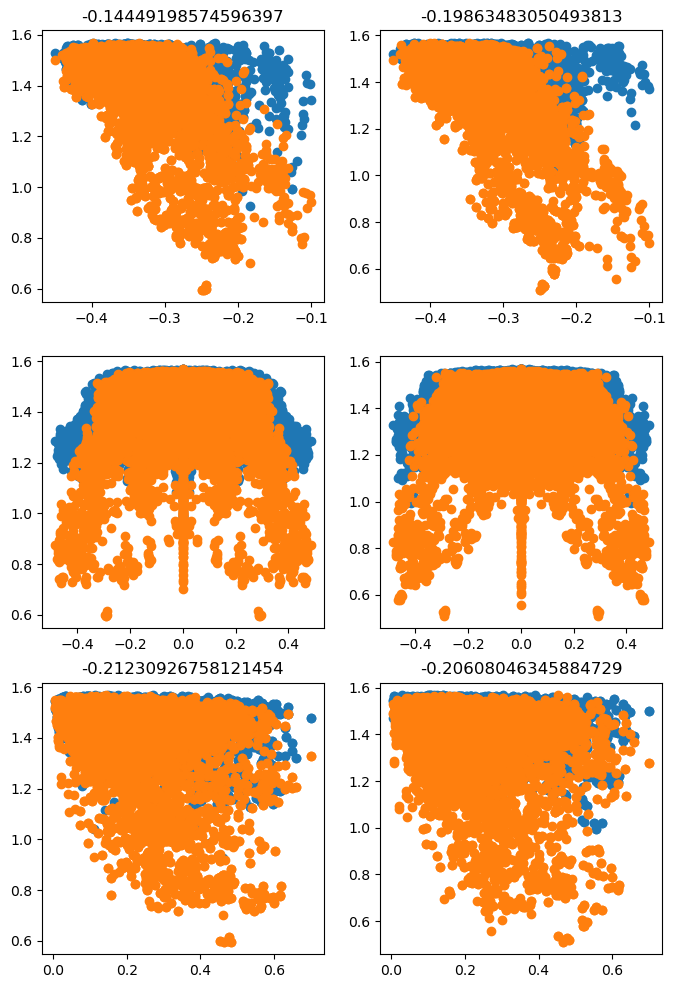

In [98]:
fig, ax = plt.subplots(3, 2, figsize=(8, 12))

df_ = apply_df_filters(eigrl, dim=2)

y1 = []
y2 = []
x = []
for i in range(df_.shape[0]):
    y1.extend(df_.iloc[i]['ssaL_f'])
    y2.extend(df_.iloc[i]['ssaR_f'])
    x.extend(np.real(df_.iloc[i]['eig']))

ax[0, 0].scatter(x, y1)
ax[0, 0].scatter(x, y2)
ax[0, 0].set_title(scipy.stats.spearmanr(x, y1)[0])

y1 = []
y2 = []
x = []
for i in range(df_.shape[0]):
    y1.extend(df_.iloc[i]['ssaL_p'])
    y2.extend(df_.iloc[i]['ssaR_p'])
    x.extend(np.real(df_.iloc[i]['eig']))

ax[0, 1].scatter(x, y1)
ax[0, 1].scatter(x, y2)
ax[0, 1].set_title(scipy.stats.spearmanr(x, y1)[0])


y1 = []
y2 = []
x = []
for i in range(df_.shape[0]):
    y1.extend(df_.iloc[i]['ssaL_f'])
    y2.extend(df_.iloc[i]['ssaR_f'])
    x.extend(np.imag(df_.iloc[i]['eig']))

ax[1, 0].scatter(x, y1)
ax[1, 0].scatter(x, y2)

y1 = []
y2 = []
x = []
for i in range(df_.shape[0]):
    y1.extend(df_.iloc[i]['ssaL_p'])
    y2.extend(df_.iloc[i]['ssaR_p'])
    x.extend(np.imag(df_.iloc[i]['eig']))

ax[1, 1].scatter(x, y1)
ax[1, 1].scatter(x, y2)


y1 = []
y2 = []
x = []
for i in range(df_.shape[0]):
    y1.extend(df_.iloc[i]['ssaL_f'])
    y2.extend(df_.iloc[i]['ssaR_f'])
    x.extend(np.abs(df_.iloc[i]['n']))

ax[2, 0].scatter(x, y1)
ax[2, 0].scatter(x, y2)
ax[2, 0].set_title(scipy.stats.spearmanr(x, y1)[0])

y1 = []
y2 = []
x = []
for i in range(df_.shape[0]):
    y1.extend(df_.iloc[i]['ssaL_p'])
    y2.extend(df_.iloc[i]['ssaR_p'])
    x.extend(np.abs(df_.iloc[i]['n']))

ax[2, 1].scatter(x, y1)
ax[2, 1].scatter(x, y2)
ax[2, 1].set_title(scipy.stats.spearmanr(x, y1)[0])


In [ ]:
# do the obvious jPCA analysis... then needs to be replicated in the SOC

In [99]:
# Next analysis: Rank eigenvectors by their peak amplitude, both implied by the model and by the data. Then correlate subspace angles/importance scores on this basis.

### Projected trajectory analysis

In [6]:
# Plot the projected, smoothed trajectories
with open('/mnt/Secondary/data/postprocessed/indy_decoding_df2.dat', 'rb') as f:
    indy_df = pickle.load(f)
indy_df = pd.DataFrame(indy_df)

with open('/mnt/Secondary/data/postprocessed/loco_decoding_df.dat', 'rb') as f:
    loco_df = pickle.load(f)
loco_df = pd.DataFrame(loco_df)
loco_df = apply_df_filters(loco_df,
                        loader_args={'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'spike_threshold': 100, 'region': 'M1'},
                        decoder_args={'trainlag': 4, 'testlag': 4, 'decoding_window': 5})
good_loco_files = ['loco_20170210_03.mat',
'loco_20170213_02.mat',
'loco_20170215_02.mat',
'loco_20170227_04.mat',
'loco_20170228_02.mat',
'loco_20170301_05.mat',
'loco_20170302_02.mat']

loco_df = apply_df_filters(loco_df, data_file=good_loco_files)        

sabes_df = pd.concat([loco_df, indy_df])

data_files = np.unique(sabes_df['data_file'].values)
dpath = '/mnt/Secondary/data/sabes'

DIM = 6

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
data_file = data_files[25]
dat = load_sabes('%s/%s' % (dpath, data_file))
dat = reach_segment_sabes(dat, data_file=data_file.split('.mat')[0])

y = np.squeeze(dat['spike_rates'])
Yproj = []
for dimreduc_method in ['LQGCA', 'PCA']:
    df_ = apply_df_filters(sabes_df, data_file=data_file, fold_idx=0, dim=DIM, dimreduc_method=dimreduc_method)
    if dimreduc_method == 'LQGCA':
        df_ = apply_df_filters(df_, dimreduc_args={'T': 3, 'loss_type': 'trace', 'n_init': 10})

    assert(df_.shape[0] == 1)
    V = df_.iloc[0]['coef']
    if dimreduc_method == 'PCA':
        V = V[:, 0:DIM]        

    # Project data
    yproj = y @ V
    yproj = np.array([yproj[t0:t0+20] for t0, t1 in dat['transition_times'] if t1 - t0 > 21])
    Yproj.append(yproj)

Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


In [13]:
from scipy.ndimage import gaussian_filter1d
from dca.methods_comparison import symmJPCA

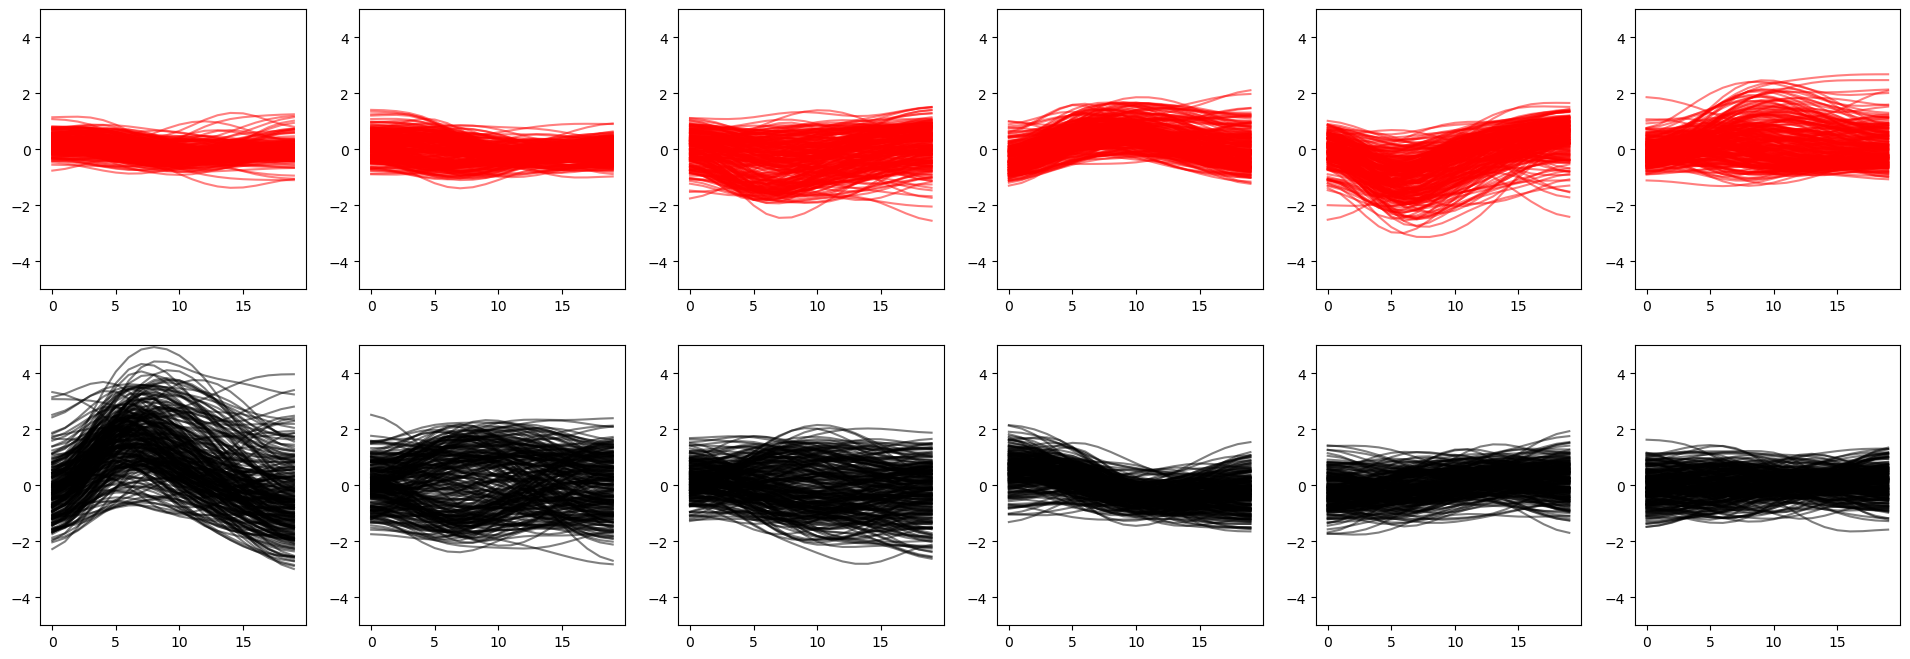

In [12]:
fig, ax = plt.subplots(2, 6, figsize=(24, 8))

for i in range(6):
    trajectory = gaussian_filter1d(Yproj[0][..., i], sigma=3, axis=1)
    ax[0, i].plot(trajectory.T, color='r', alpha=0.5)
    trajectory = gaussian_filter1d(Yproj[1][..., i], sigma=3, axis=1)
    ax[1, i].plot(trajectory.T, color='k', alpha=0.5)
    ax[0, i].set_ylim([-5, 5])
    ax[1, i].set_ylim([-5, 5])

In [39]:
# How do we pull this effect out?

# Center at 0
y0centered = np.array([y_[0:10] - y_[0:1, :] for y_ in Yproj[0]])
y1centered = np.array([y_[0:10] - y_[0:1, :] for y_ in Yproj[1]])
#y0centered = Yproj[0]
#y1centered = Yproj[1]
# First, verify that jpcasymm does not pull it out:
y0centered = gaussian_filter1d(y0centered, sigma=3, axis=1)
y1centered = gaussian_filter1d(y1centered, sigma=3, axis=1)

j1 = symmJPCA(n_components=DIM, mean_subtract=False)
j1.fit(y0centered)
j2 = symmJPCA(n_components=DIM, mean_subtract=False)
j2.fit(y1centered)

In [40]:
j1.eigen_vals_

array([0.09296411, 0.07267624, 0.0659768 , 0.04493793, 0.03542599,
       0.02345466])

In [41]:
j2.eigen_vals_

array([0.07875887, 0.05622138, 0.05022737, 0.03913499, 0.03040823,
       0.02332957])

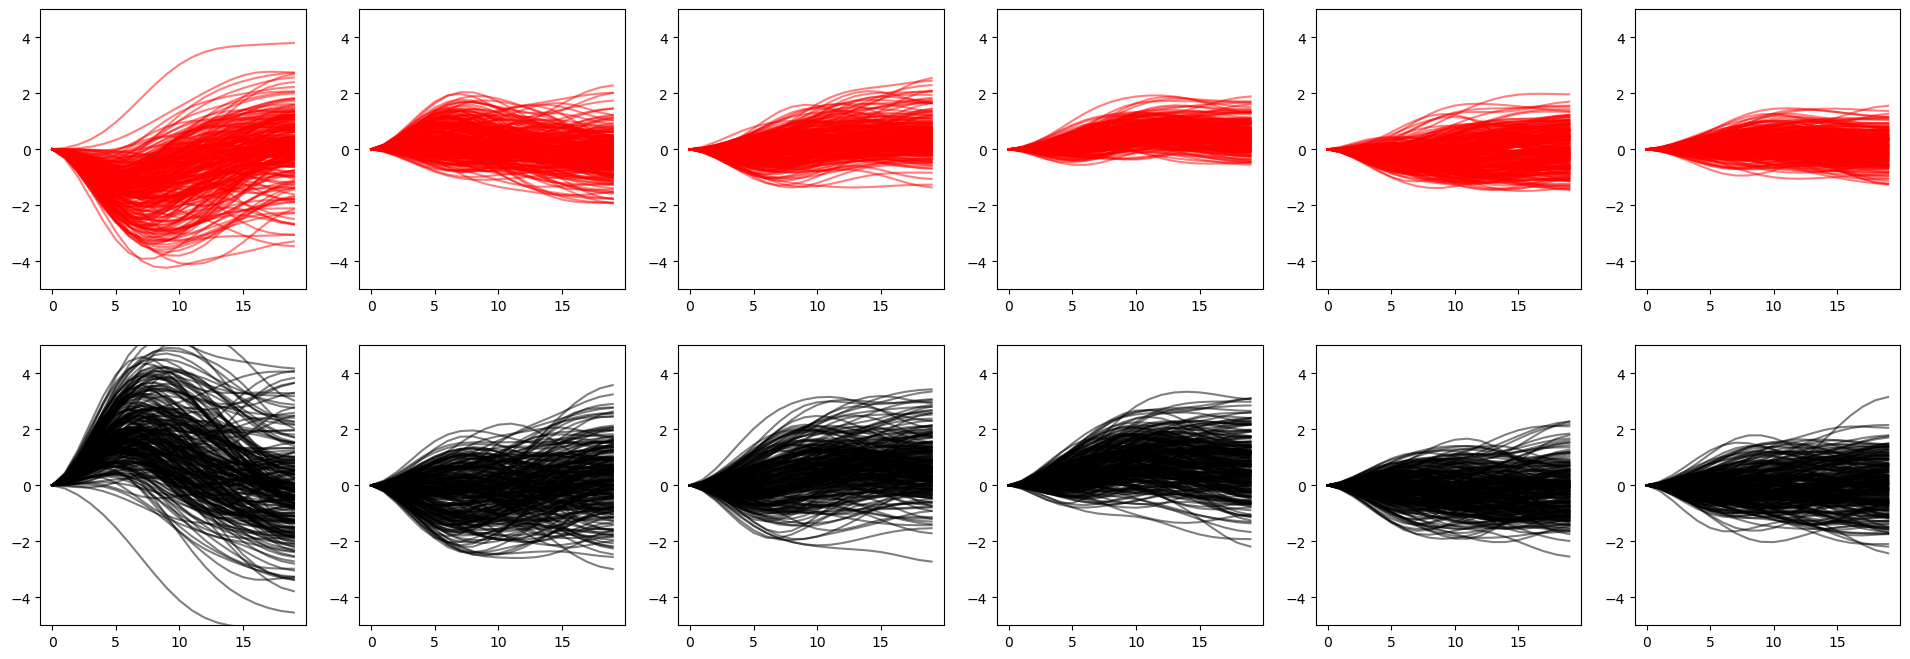

In [26]:
fig, ax = plt.subplots(2, 6, figsize=(24, 8))

Ytrans0 = j1.transform(Yproj[0])
Ytrans1 = j2.transform(Yproj[1])

for i in range(6):
    trajectory = gaussian_filter1d(Ytrans0[..., i], sigma=3, axis=1)
    trajectory -= trajectory[:, 0:1]
    ax[0, i].plot(trajectory.T, color='r', alpha=0.5)
    trajectory = gaussian_filter1d(Ytrans1[..., i], sigma=3, axis=1)
    trajectory -= trajectory[:, 0:1]
    ax[1, i].plot(trajectory.T, color='k', alpha=0.5)
    ax[0, i].set_ylim([-5, 5])
    ax[1, i].set_ylim([-5, 5])

In [17]:
j1.eigen_vals_

array([-0.27588698, -0.38636364, -0.40807524, -0.5340319 , -0.60254752,
       -0.63025349])

In [18]:
j2.eigen_vals_

array([-0.29130812, -0.43939038, -0.56547453, -0.74558593, -0.85543965,
       -0.86994033])

In [20]:
Ytrans0.shape

(247, 20, 6)

In [47]:
# Average dynamic range?
Ytranscent0 = Ytrans0 - Ytrans0[:, 0:1, :]
Ytranscent1 = Ytrans1 - Ytrans1[:, 0:1, :]
dyn_range0 = [np.max(np.abs(Ytranscent0[i, :, j])) for i in range(Ytrans0.shape[0]) for j in range(Ytrans0.shape[-1])]
dyn_range1 = [np.max(np.abs(Ytranscent1[i, :, j])) for i in range(Ytrans1.shape[0]) for j in range(Ytrans1.shape[-1])]

(array([170., 494., 408., 177.,  88.,  53.,  41.,  38.,   9.,   4.]),
 array([ 1.31839089,  2.27475513,  3.23111938,  4.18748362,  5.14384786,
         6.10021211,  7.05657635,  8.01294059,  8.96930484,  9.92566908,
        10.88203332]),
 <BarContainer object of 10 artists>)

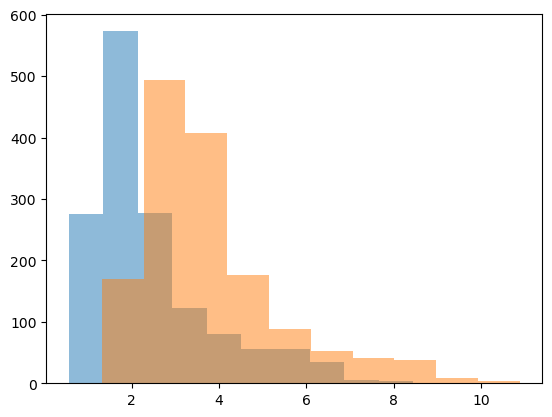

In [48]:
plt.hist(dyn_range0, alpha=0.5)
plt.hist(dyn_range1, alpha=0.5)